# Probability Modelling in fmdtools
Here we will demonstrate the fmdkit's abilities to find a set of scenarios that represent the effects of a given mode.

In [1]:
#First, import the fault propogation library as well as the model
#since the package is in a parallel location to examples...
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmdtools.faultprop as fp
import fmdtools.resultproc as rp
import quadpy
from ex_pump import *
from IPython.display import HTML
mdl = Pump()

## Theory and Goals

Small problem description (see paper?)


### Ideas

- monte carlo with and without variance reduction

- quadrature (from quadpy)

- sample likeliest phase (`maxlike`)


## Model Description
 - pump: functions/flows, phases, faults, etc
 - different utility models:
 - - repair cost
 - - lost water cost
 - - ee use cost
 - - delay / no delay

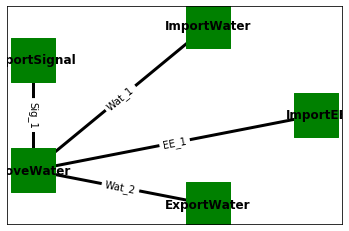

In [2]:
rp.show_graph(mdl.graph)

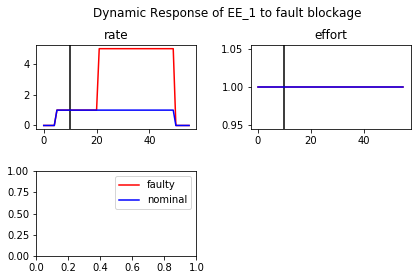

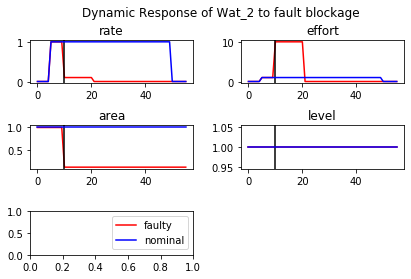

In [3]:
endresults, resgraph, mdlhist=fp.run_one_fault(mdl, 'ExportWater', 'block', time=10, staged=True)
#rp.show_graph(resgraph)
rp.plot_mdlhist(mdlhist, 'blockage', time=10, fxnflows=['Wat_2', 'EE_1'])

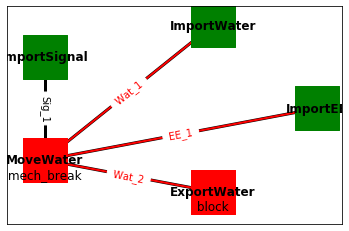

0

In [4]:
reshist,diff1, summary = rp.compare_hist(mdlhist)
rp.plot_resultsgraph_from(mdl, reshist, 45, scale=2.0, gtype='normal')

## Experiments

- Compare percent error and evaulation time for each strategy by sampling strategy/num pts (center, 3, 9) for even sampling, monte carlo, max likelihood, etc
- Compare percent error across cost types (repair, water, ee, full) and show the modes where error is most prevalent
- Find single-point sample that minimizes error with the with the full utility (for maxlike and center point formulations)
- Try to understand uncertainties in rates, costs
- What are the things we know, don't know (things we don't know => uncertainty)

The function below calculates the expected resilience of a model using a given sampling approach

In [5]:
def resilquant(approach, mdl):
    endclasses, mdlhists = fp.run_approach(mdl, approach)
    reshists, diffs, summaries = rp.compare_hists(mdlhists)
    
    fmea = rp.make_summfmea(endclasses, approach)
    fmea2 = rp.make_phasefmea(endclasses, approach)
    util=sum(fmea['expected cost'])
    expdegtimes = rp.make_expdegtimeheatmap(reshists, endclasses)
    return util, expdegtimes, fmea, fmea2

This function calculates error between the full utility and a sampled utility measure.

In [6]:
def calcerror(fullutil, util):    
    return abs((fullutil-util)/fullutil)

Calculating the full integral and likeliest phase estimates:

In [7]:
app_full = SampleApproach(mdl, defaultsamp={'samp':'fullint'})
util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)

In [8]:
app_maxlike = SampleApproach(mdl, defaultsamp={'samp':'likeliest'})
util_maxlike, expdegtimes_maxlike, fmea_maxlike, phasefmea_maxlike = resilquant(app_maxlike, mdl)

In [56]:
quadratures = {}

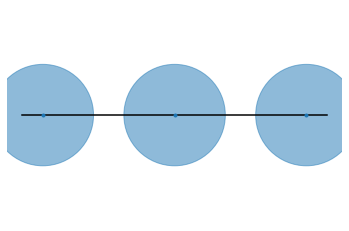

In [57]:
quadratures['chebyshef-gauss 1'] = quadpy.line_segment.chebyshev_gauss_1 #argument is # of points
quadratures['chebyshef-gauss 1'](3).show()

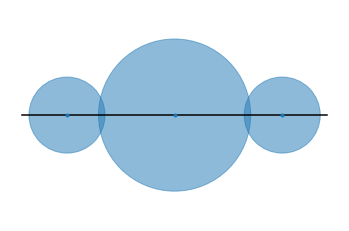

In [58]:
quadratures['chebyshef-gauss 2'] = quadpy.line_segment.chebyshev_gauss_2 #argument is # of points
quadratures['chebyshef-gauss 2'](3).show()

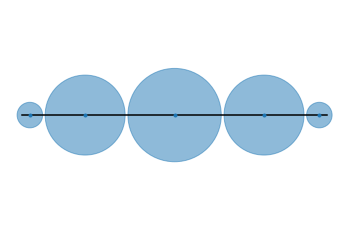

In [59]:
quadratures['fejer 1'] = quadpy.line_segment.fejer_1 #argument is # of points
quadratures['fejer 1'](5).show()

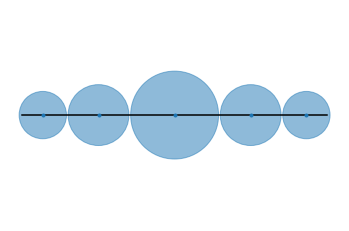

In [60]:
quadratures['fejer 2'] = quadpy.line_segment.fejer_2 #argument is # of points
quadratures['fejer 2'](5).show()

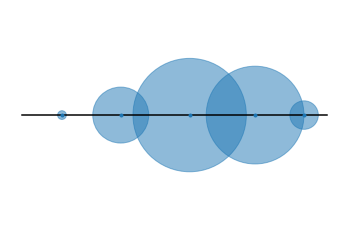

In [61]:
#DIFFERENT ARGUMENT, SO I'LL LEAVE IT OUT FOR NOW
gauss_jacobi = quadpy.line_segment.gauss_jacobi(5, 1,2) #argument is # of points, left weighting, right weighting > -1
# maybe test a few weightings (e.g. right vs left bias)
gauss_jacobi.show() 
app_gauss_jacobi = SampleApproach(mdl, defaultsamp={'samp':'quadrature','quad':gauss_jacobi})

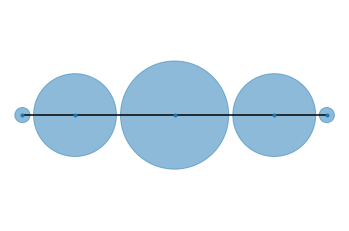

In [62]:
quadratures['gauss lobatto'] = quadpy.line_segment.gauss_lobatto #argument is # of points
quadratures['gauss lobatto'](5).show() 

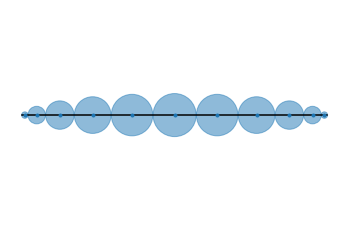

In [63]:
#argument is n which makes the number off pts 2*n+1
quadratures['gauss kronrod'] = quadpy.line_segment.gauss_kronrod
quadratures['gauss kronrod'](5).show() 

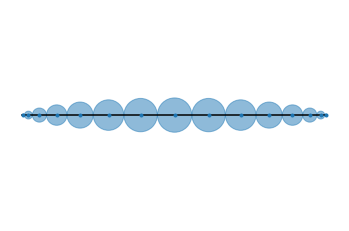

In [64]:
#argument is the order n, num pts is [1, 3, 7, 15, 31, 63, 127, 255 or 511]
quadratures['gauss pattersion'] = quadpy.line_segment.gauss_patterson 
quadratures['gauss pattersion'](3).show()

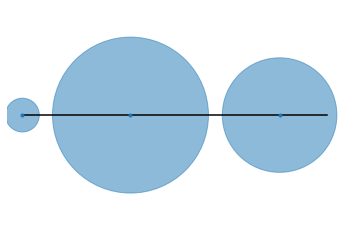

In [65]:
#argument is number of pts, (optional) bias left, bias right (maybe try flipping?)
quadratures['gauss radau'] = quadpy.line_segment.gauss_radau
quadratures['gauss radau'](3).show()

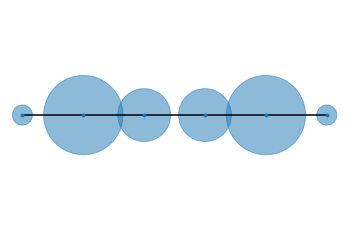

In [66]:
#argument is n which makes the number of pts n+1
quadratures['newton cotes closed'] = quadpy.line_segment.newton_cotes_closed 
quadratures['newton cotes closed'](5).show()

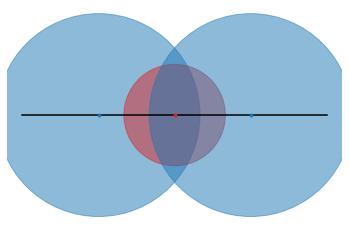

In [67]:
quadratures['newton cotes open'] = quadpy.line_segment.newton_cotes_open #argument num of pts
quadratures['newton cotes open'](3).show() 

The code below calculates the error of each approach over the number of points used. For the monte-carlo approaches, the results are averaged over 10 simulations and the standard deviation is provided for error bars. The computational cost is also determined by determined by taking the number of simulations needed for each (which is 1 per point (from simulating the nominal) and a fraction based on the injection time of the simulation (faults injected later take less time in simulation)).

Text(0.5, 1.0, 'Error of Sampling Approaches')

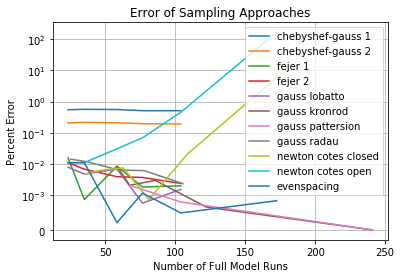

In [71]:
possible_pts = [2,3,5,9,15, 30]
errs = dict.fromkeys(quadratures)
num_samps = dict.fromkeys(quadratures)
for quadname, quad in quadratures.items():
    errs[quadname] = []
    num_samps[quadname] = []
    for pt in possible_pts:
        try:
            app=SampleApproach(mdl,defaultsamp={'samp':'quadrature','quad':quad(pt)})
            util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
            errs[quadname] = errs[quadname] + [calcerror(util_full, util)]
            num_samps[quadname] = num_samps[quadname] + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
        except: 0
    plt.plot(num_samps[quadname], errs[quadname], label=quadname)
errs['evenspacing'] = []
num_samps['evenspacing'] = []
for pt in possible_pts:
    app=SampleApproach(mdl,defaultsamp={'samp':'evenspacing','numpts':pt})
    util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
    errs['evenspacing'] = errs['evenspacing'] + [calcerror(util_full, util)]
    num_samps['evenspacing'] = num_samps['evenspacing'] + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
plt.plot(num_samps['evenspacing'], errs['evenspacing'], label='evenspacing')
    
plt.legend(loc='upper right')
plt.xlabel("Number of Full Model Runs")
plt.yscale("symlog", linthreshy=0.001)
plt.grid('both')
plt.ylabel("Percent Error")
plt.title("Error of Sampling Approaches")

In [25]:
app=SampleApproach(mdl,defaultsamp={'samp':'quadrature','quad':quad(30)})

In [ ]:
possible_pts=[1,3,5,9,15, 30]
samp_types = ['evenspacing', 'randtimes', 'symrandtimes']
errs=dict.fromkeys(samp_types)
errbars=dict.fromkeys(samp_types)
errbar_samps = dict.fromkeys(samp_types)
num_samples = dict.fromkeys(samp_types)
ave_pts=10
for samp_type in samp_types:
    errs[samp_type]=[]
    errbars[samp_type]=[]
    num_samples[samp_type]=[]
    errbar_samps[samp_type] = []
    for pt in possible_pts: #calc errors
        if samp_type in ['randtimes', 'symrandtimes']:
            samperrs=[]
            samps = []
            for ave_pt in range(ave_pts):
                app=SampleApproach(mdl,defaultsamp={'samp':samp_type, 'numpts':pt})
                util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
                samperrs=samperrs+[calcerror(util_full, util)]
                samps = samps + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
            err=np.mean(samperrs)
            errbar=np.std(samperrs)
            num_samps= np.mean(samps)
            errbar_samp = np.std(samps)
        else:
            app=SampleApproach(mdl,defaultsamp={'samp':samp_type, 'numpts':pt})
            util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
            err = calcerror(util_full, util)
            errbar=0.0
            num_samps = len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])
            errbar_samp = 0.0
        errs[samp_type]=errs[samp_type]+[err]
        errbars[samp_type]=errbars[samp_type]+[errbar]
        num_samples[samp_type] = num_samples[samp_type] + [num_samps]
        errbar_samps[samp_type] = errbar_samps[samp_type] + [errbar_samp]
    #plt.errorbar(possible_pts, errs[samp_type],yerr=errbars[samp_type], marker='o', label=samp_type)
#plt.legend()
#plt.xlabel("Number of Sample Points")
#plt.yscale("log")
#plt.ylabel("Percent Error")
#plt.title("Error of Sampling Approaches")
#plt.grid('both')

This code makes a nice plot out of those results and calculates computational cost for the full integral and likeliest phase sampling approaches.

In [ ]:
errbar_samps['full'] = [0.0]
errs['full']=[0.0]
errbars['full']=[0.0]
num_samples['full'] = [len(app_full.times) + sum([(55-scen['properties']['time'])/55 for scen in app_full.scenlist])]

errbar_samps['likeliest'] = [0.0]
errs['likeliest']=[calcerror(util_full, util_maxlike)]
errbars['likeliest']=[0.0]
num_samples['likeliest'] = [len(app_maxlike.times) + sum([(55-scen['properties']['time'])/55 for scen in app_maxlike.scenlist])]


for samp in num_samples:
    plt.errorbar(num_samples[samp], errs[samp], yerr=errbars[samp], marker='o', label=samp)
#plt.errorbar(range(len(num_samps)), list(num_samps.values(), )
#plt.xticks(range(len(num_samps)), list(num_samps.keys())
plt.legend(loc='upper right')
plt.xlabel("Number of Full Model Runs")
plt.yscale("symlog", linthreshy=0.001)
plt.grid('both')
plt.ylabel("Percent Error")
plt.title("Error of Sampling Approaches")


So both types of random sampling are dominated by the most probable phase sampling and the multipoint strategy in this case.

#### Error accross model considerations:
Here I compare the error of the center-point strategy accross different model considerations and accross different modes.

In [ ]:
#calc resiliences for all appraches
app_center = SampleApproach(mdl)
util_params = [['repair'], ['ee'], ['water'],['repair','ee','water']]
mdl=Pump()
util_center, expdegtimes_center, fmea_center, phasefmea_center = resilquant(app_center, mdl)

error_models={}
error_fmea={}
for util_param in util_params:
    for delay in [[],['delay']]:
        mdl = Pump(params=set(util_param+delay))
        util_center, expdegtimes_center, fmea_center, phasefmea_center = resilquant(app_center, mdl)
        util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
        error_models[str(util_param),str(delay)]=calcerror(util_full, util_center)
        error_fmea[str(util_param),str(delay)] = (phasefmea_full['expected cost']-phasefmea_center['expected cost'])/(phasefmea_full['expected cost']+0.001)

In [ ]:
rp.make_dicttable(error_models)

In [ ]:
error_fmea_table = pd.concat(error_fmea.values(), axis='columns', keys=error_fmea.keys())

def color_error_red(val):
    if abs(val)>0.01:
        color='red'
    elif val!=0.0:
        color='orange'
    else:
        color='black'
    return 'color: %s' % color
error_fmea_table_stylized = error_fmea_table.style.applymap(color_error_red)
error_fmea_table_stylized

So the error was predominantly introduced by the delay. Thus our main issue for error in the center-point strategy is if there is any resulting timely degradation that may be cut off by the interval (e.g. if the system is turned off before there is damage). In fact, we can imagine the center-point strategy having quite large error if the degradation time becomes roughly the time of the interval.

This may be salient for any model more complicated than this one, especially when there are somewhat sophisticated utility functions, degradation behaviors, or recovery actions.

It should be noted: there is also some error from faults that occur at the edge of a phase, since more or less damage can occur depending on the operational phase. This is the case with the inf_v fault, which doesn't have time to cause damage when the fault is injected, since faults are injected at the end of the next timestep. This is unaviodable without running additional timesteps before or after a fault is injected to 

In [ ]:
error_fmea_table.to_latex();